# Homework: Week 4

## Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## Loading Data

In [2]:
! wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-04 12:09:57--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1,4M) [text/plain]
Saving to: ‘data.csv.16’

data.csv.16         100%[===================>]   1,41M  --.-KB/s    in 0,1s    

2023-10-04 12:09:57 (11,1 MB/s) - ‘data.csv.16’ saved [1475504/1475504]



In [3]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'
df = pd.read_csv(url)
#df.info()
#df.head().T

## Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [4]:
cols_to_use = ['Make',
                'Model',
                'Year',
                'Engine HP',
                'Engine Cylinders',
                'Transmission Type',
                'Vehicle Style',
                'highway MPG',
                'city mpg',
                'MSRP']

df = df[cols_to_use]
#df.head().T

In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
#df.columns

In [6]:
#display(df.isnull().sum())
df.fillna(0, inplace=True)
#display(df.isnull().sum())

In [7]:
average_price = df['msrp'].mean()
df['above_average'] = (df['msrp'] > average_price).astype(int)
df['above_average'] = df['above_average'].astype('bool')
#df.info()
#df.head().T

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(len(df_train), len(df_val), len(df_test))


df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

7148 2383 2383


## Question 1: ROC AUC feature importance

In [9]:
num_cols = df_train.select_dtypes(include=['number']).columns  # Numeric columns (int and float)
cat_cols = df_train.select_dtypes(include=['object']).columns  # Categorical columns
bool_columns = df_train.select_dtypes(include=['bool']).columns  # Boolean columns

for c in cat_cols:
    df_train[c] = df_train[c].str.lower().str.replace(' ', '_')
    df_val[c] = df_val[c].str.lower().str.replace(' ', '_')
    df_test[c] = df_test[c].str.lower().str.replace(' ', '_')

print(num_cols)
print(cat_cols)
print(bool_columns)

Index(['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg'], dtype='object')
Index(['make', 'model', 'transmission_type', 'vehicle_style'], dtype='object')
Index([], dtype='object')


In [10]:
feature_aucs = {}
for feature in num_cols:
    auc = roc_auc_score(y_train, df_train[feature])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[feature])

    feature_aucs[feature] = auc


highest_auc_feature = max(feature_aucs, key=feature_aucs.get)
print(highest_auc_feature)

engine_hp


## Question 2: Training the model

In [11]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[list(cat_cols) + list(num_cols)].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[list(cat_cols) + list(num_cols)].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [12]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [13]:
y_pred = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred)

0.9809889933018856

## Question 3: Precision and Recall

In [14]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    
    df_scores['f1_score'] = 2* (df_scores['precision']*df_scores['recall'])/(df_scores['precision'] + df_scores['recall'])

    return df_scores

In [15]:
df_pred = tpr_fpr_dataframe(y_val, y_pred)

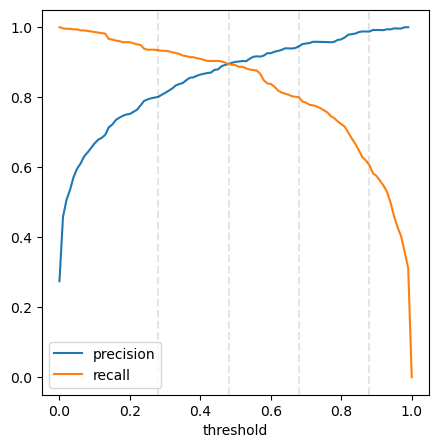

In [16]:
ans_list = [0.28,0.48,0.68,0.88]

fig, ax = plt.subplots(figsize=(5,5))
df_pred[['threshold', 'precision', 'recall']].plot(x='threshold', ax=ax)
for ans in ans_list:
    ax.axvline(x=ans, ls='--', alpha=0.1, color='k')

## Question 4: F1 score

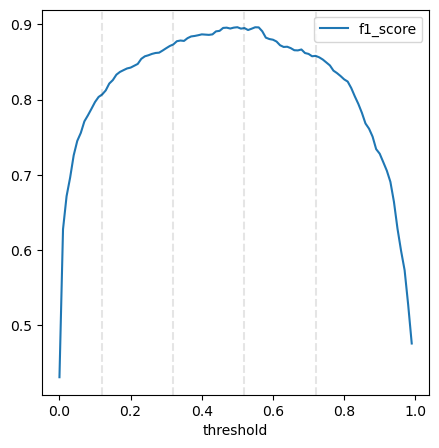

In [17]:
ans_list = [0.12,0.32,0.52,0.72]

fig, ax = plt.subplots(figsize=(5,5))
df_pred[['threshold', 'f1_score']].plot(x='threshold', ax=ax)
for ans in ans_list:
    ax.axvline(x=ans, ls='--', alpha=0.1, color='k')

## Question 5: 5-Fold CV

In [18]:
! pip install tqdm

In [19]:
from tqdm.auto import tqdm

In [20]:
def train(df_train, y_train,C=1.0):
    dicts = df_train[list(cat_cols) + list(num_cols)].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[list(cat_cols) + list(num_cols)].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [21]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for idx, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    del df_train['msrp']
    del df_val['msrp']

    del df_train['above_average']
    del df_val['above_average']

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

    print(f'Fold {idx+1}: {auc}')

print('Mean Score: %.3f +- %.3f' % (np.mean(scores), np.std(scores)))

Fold 1: 0.9784808734152847
Fold 2: 0.9807252495931742
Fold 3: 0.9850524231777369
Fold 4: 0.9772656293569797
Fold 5: 0.9776806526806527
Mean Score: 0.980 +- 0.003


## Question 6: Hyperparemeter Tuning

In [22]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for idx, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        del df_train['msrp']
        del df_val['msrp']

        del df_train['above_average']
        del df_val['above_average']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.002
C=0.5 0.977 +- 0.002
C=10 0.981 +- 0.002
